# GDL - Regular Group Convolutions

**Filled notebook:**[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Geometric_deep_learning/tutorial1_regular_group_convolutions_answered.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/david-knigge/3fe75ea105f8d8a75afad2c1a3669915/tutorial1_regular_group_convolutions_answered.ipynb)

**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/DL2/GDL/)   
**Authors:**
David Knigge

## 0. Introduction

Σε αυτό το Jupyter Notebook, θα πραγματοποιηθεί η υλοποίηση των κανονικών ομαδο-συνελικτικών νευρωνικών δικτύων απο το μηδέν.Για τον σκοπό αυτό θα χρησιμοποιηθεί η βιβλιοθήκη Pytorch και άλλες βασικά API για νευρωνικά δίκτυα.Ο στόχος είναι 
η έμπρακτη εξοικείωση για την εφαρμογή αυτών των συνελικτικών δικτύων.


### 0.1 Σύντομη Ανακεφαλαίωση των CNN's

Τα συμβατικά Συνελικτικά Νευρωνικά Δίκτυα (CNN's) κάνουν χρήση του τελεστή συνέλιξης , ο οποίος ορίζεται στο χώρο $\mathbb{R}^2$ για ένα σήμα $f:\mathbb{R}^2 \rightarrow \mathbb{R}$ και έναν πυρήνα mathbb{R}^2 \rightarrow \mathbb{R}$ στο σημείο $\mathbf{x}\in \mathbb{R}^2$:

$$
(f * k) (\mathbf{x}) =
    \int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k(\tilde{\mathbf{x}} - \mathbf{x}) \text{d}\tilde{\mathbf{x}},
$$

Όπως παρατηρείται , η συνέλιξη προκύπτει ως ένα εσωτερικό γινόμενο της συνάρτησης $f$  και ενός μετατοπισμένου πυρήνα $k$.


> Σημείωση: Στην πραγματικότητα, τα CNNs υλοποιούν μία διακριτοποιημένη εκδοχή αυτής της διαδικασίας:
$$
\begin{aligned}
(f*k) (\mathbf{x}) &= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})\Delta\mathbf{\tilde{x}}\\
&= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})
\end{aligned}
$$   

Παραπάνω, επειδή τα pixel σε μία εικόνα συνήθως ισαπέχουν, ορίζεται το $\Delta \mathbf{\tilde{x}}=1$. Για την παρούσα ανακεφαλαίωση 
η ανάλυση γίνεται στον συνεχή χώρο για απλότητα.

Στα επίπεδα συνέλιξης, όπως στην υλοποίηση `Conv2D` της PyTorch,η παραπάνω πράξη πραγματοποιείται για κάθε σημείο $\mathbf{x} \in \mathbb{Z}^2$ (περιορισμένο φυσικά, στο χώρο στον οποίο ορίζεται η εικόνα). Επειδή το ίδιο σύνολο βαρών χρησιμοποιείται σε όλη την είσοδο, το αποτέλεσμα αυτής της πράξης είναι [ισοδύναμο](https://en.wikipedia.org/wiki/Convolution#Translational_equivariance) σε μετασχηματισμούς της ομάδας μετατοπίσεων $\mathbb{R}^2$. Επιπλέον,οι $f,k$ συνήθως αποτελούνται από αρκετά κανάλια , τα οποία αθροίζονται.

Στις παρακάτω υλοποιήσεις, θα χρησιμοποιηθεί η συνάρτηση `torch.nn.functional.conv2d()` της PyToch για να πραγματοποιηθεί αυτή η πράξη ολοκλήρωσης σε κάθε σημείο του χάρτη χαρακτηριστικών εισόδου.Αυτή η προσέγγιση εξοικονομεί την ανάγκη υλοποίησης της πράξης συνέλιξης από την αρχή.


### 0.2 Σύντομη Ανακεφαλαίωση των GCNN's

Στα κανονικά ομαδο-συνελικτικά δίκτυα, ο στόχος είναι ένα CNN που δεν είναι μόνο ισοδύνομο στις μετατοπίσεις στο $\mathbb{R}^2$,αλλα να είναι ισοδύναμη και σε κάποια άλλη (συνήθως ευρύτερη) ομάδα ενδιαφέροντος $G$.Η βασική εστίαση θα γίνει σε ομάδες που είναι συνδυασμοί μετατοπίσεων στο $\mathbb{R}^2$ και κάποιας ομάδας ενδιαφέροντος $H$. Στη συγκεκριμένη υλοποίηση ,χρησιμοποιείται η ομάδα των περιστροφών κατα 90 μοίρες σε δισδιάστατες εικόνες, την [Κυκλική Ομάδα](https://en.wikipedia.org/wiki/Cyclic_group) τάξης $4$ $H=C_4$.

$$
(f *_{\text{lifting}} k) (g) =
\int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k_h(\tilde{\mathbf{x}} - \mathbf{x}) \,{\rm d}\tilde{\mathbf{x}}.
$$

Όπου $k_h$ είναι ο πυρήνας $k:\mathbb{R}^2 \rightarrow \mathbb{R}$ μετασχηματισμένος υπό την κανονική αναπαράσταση $\mathcal{L}_h$ ενός στοιχείου της ομάδας $h \in H$; $k_h = \frac{1}{| h|}\mathcal{L}_{h}[k]$.

> Σημείωση: Ο παράγοντας $\frac{1}{| h|}$, με $|h|$ η ορίζουσα της αναπαράστασης του πίνακα του $h$ στο  $\mathbb{R}^2$, αντιστοιχεί στην πιθανή αλλαγή όρκου στο  $\mathbb{R}^2$ που μπορεί να προκαλέσει το στοιχείο $h$.Ωστόσο ,για την κυκλική ομάδα ,που χρησιμοποιείται,δεν εμφανίζεται αυτό το πρόβλημα (η ορίζουσα ενός πίνακα περιστροφής είναι 1, καθώς ο όγκος παραμένει αμετάβλητος στις περιστροφές στο $\mathbb{R}^2$).Αντίθετα, στην περίπτωση της ομάδας διαστολής (dilation), κάτι τέτοιο δεν ισχύει.

Αφού, υπάρχει ένας χάρτης χαρακτηριστικών ορισμένος στην ομάδα ,$f_{out}:G\rightarrow \mathbb{R}$ εφαρμόζεται η συνέλιξη ομάδας,επεκτείνοντας τη συνελικτική λειτουργία σε ένα ολοκλήρωμα πάνω σε ολόκληρη την ομάδα $G$.
$$
\begin{aligned}
(f *_{\mathrm{group}} k) (g) &=\int_G f(\tilde{g})k(g^{-1} \cdot \tilde{g}) {\rm d}\tilde{g} \\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}}, \tilde{h})\mathcal{L}_{x}\mathcal{L}_{h}k(\tilde{\mathbf{x}}, \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}\\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}},\tilde{h})k({h^{-1}}(\tilde{\mathbf{x}}-\mathbf{x}), h^{-1}\cdot \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}.
\end{aligned}
$$

Η κύρια διαφορά με τη συνελικτική ανύψωση είναι ότι τόσο το σήμα όσο και ο πυρήνας $f,k$ είναι συναρτήσεις της ομάδας $G$,δηλαδή, $G\rightarrow \mathbb{R}$, και το ολοκλήρωμα το αντανακλά αυτό επεκτείνοντάς το σε ολόκληρη την ομάδα $G$. Δεν υπάρχουν άλλες διαφορές.

Μετά από μερικά επίπεδα συνελίξεων ομάδας, ο τελικός στόχος είναι να εξαχθεί μία αναπαράσταση που είναι αμετάβλητη στη δράση της ομάδας. Αυτό επιτυγχάνεται με την πραγματοποίηση μιας προβολής που συμπιέζει τη συνάρτηση , η οποία είναι ορισμένη στην ομάδα 
$G$, σε ένα σημείο,χρησιμοποιώντας μια λειτουργία που είναι αμετάβλητη στη δράση της ομάδας (άθροιση,μέση τιμή,μέγιστη τιμή,ελάχιστη τιμή).

Μετά από αυτή τη σύντομη ανακεφαλαίωση,ακολουθεί ο κώδικας της υλοποίησης.


### 0.3 Εγκατάσταση και εισαγωγή χρήσιμων πακέτων

Παρακάτω,εγκαθίστανται ορισμένες βιβλιοθήκες που χρησιμοποιούνται σε όλη την υλοποίηση.Χρησιμοποιείται η [PyTorch](https://pytorch.org/) ως το πλαίσιο (framework) βαθιάς μάθησης.Για να διευκολυνθεί η διαδικασία εκπαίδευσης και παρακολούθησης του μοντέλου, χρησιμοποιείται το  
[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/).


In [2]:
## Standard libraries
import os
import numpy as np
import math
from PIL import Image
from functools import partial

## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
## PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install pytorch-lightning>=1.4 --quiet
    import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [3]:
# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/DL2/GDL"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"
# Files to download
files = ["paprika.tiff"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## 1. Group theory

### 1.1 Τι είναι μια ομάδα?

Για αρχή , θα γίνει μια μικρή ανακεφαλαίωση σε μερικά βασικά στοιχεία της θεωρίας ομάδων.Μια ομάδα ,ορίζεται απο το ζεύγος $(G, \cdot)$,όπου $G$ είναι το σύνολο των στοιχείων της ομάδας και $\cdot$ η δυαδική δράση της ομάδας ,που υποδηλώνει τον τρόπο συνδυασμού των στοιχείων $g \in G$. Η δράση της ομάδας $\cdot$ πρέπει να ικανοποιεί τα εξής:


1.   Ιδιότητα της Κλειστότητας: Το $G$ είναι κλειστό υπό την $\cdot$. Για όλα τα $g_1, g_2 \in G$ έχουμε $g_1 \cdot g_2 \in G$.
2.   Ύπαρξη του Ουδέτερου Στοιχείου: Υπάρχει ένα στοιχείο ταυτότητας $e$ τέτοιο ώστε για κάθε $g \in G$, έχουμε $e \cdot g = g \cdot e = g$.
3.   Ύπαρξη του Συμμετρικού Στοιχείου: Για κάθε στοιχείο $g \in G$, υπάρχει ένα στοιχείο $g^{-1} \in G$, έτσι ώστε $g \cdot g^{-1} = e$.
4.   Ιδιότητα του Προσεταιρισμού: Για κάθε σύνολο στοιχείων $g_1, g_2, g_3 \in G$, έχουμε $(g_1 \cdot g_2) \cdot g_3 = g_1 \cdot (g_2 \cdot g_3)$.

Η ομάδα μπορεί να δράσει πάνω σε συναρτήσεις ορισμένες στο $\mathbb{R}^2$, η οποία υλοποιείται μέσω της *κανονικής αναπαράστασης* $\mathcal{L}_g^{\mathbb{G}\rightarrow \mathbb{R}^2}$.Για απλότητα, γράφεται $\mathcal{L}_g$. Ορίζεται από:

$$
\mathcal{L}_g f (\mathbf{x}) = f(g^{-1} \cdot \mathbf{x})
$$

Όπου η δράση του $g^{-1}$ στο $x$ γράφεται ως $g^{-1}\cdot \mathbf{x}$.

Αυτή η κανονική αναπαράσταση χρησιμοποιείται για να μετασχηματίσει τους πυρήνες 
$k$ που χρησιμοποιούνται σε όλο το δίκτυο, και γι' αυτό το λόγο η κανονική συνέλιξη ομάδας παίρνει το όνομά της.


### 1.2 Υλοποίηση της Ομαδας στην Python

Αρχικά θα παρουσιαστεί η βασική κλάση στην οποία θα καθοριστούν ποιές λειτουργί-
ες θα χρειαστούν για την χρήση της δομής των ομάδων στο πλαίσιο των νευρωνικών
δικτύων. Τα ομαδo-συνελικτικά νευρωνικά δίκτυα θα υλοποιηθούν χρησιμοποιώντας
τη βιβλιοθήκη torch, όπου η δομή της ομάδας θα καθιερωθεί ως ενότητα (module) της
torch.

Πρώτα, ορίζεται η βασική κλάση GroupBase ,όπου καθορίζονται όλες οι βασι-
κές ιδιότητες και λειτουργίες που απαιτούνται για τη διαχείριση των ομαδο-συνελικτικών
νευρωνικών δικτύων. Ο πρωταρχικός στόχος της δημιουργίας αυτής της κλάσης είναι
να παρέχει τις απαραίτητες και επαρκείς λειτουργίες για την επέκτασή της σε άλλες
δομές ομάδας, εκτός από αυτή που εφαρμόζεται σε αυτή την εργασία. Ουσιαστικά,
εάν κάποιος επιθυμεί να υλοποιήσει ομαδο-συνελικτικές λειτουργίες , για μία νέα ο-
μάδας απλώς κληρονομεί αυτή τη βασική κλάση και υλοποιεί τις μεθόδους της .Στην
πράξη ,βέβαια, είναι σημαντικό να σημειωθεί ότι αυτό ισχύει πιστά μόνο για διακρι-
τές,συμπαγείς ομάδες.
37

In [5]:
class GroupBase(torch.nn.Module):

    def __init__(self, dimension, identity):
        """ Implements a group.

        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group.
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.

        """
        raise NotImplementedError()

    def product(self, h, h_prime):
        """ Defines group product on two group elements.

        @param h: Group element 1
        @param h_prime: Group element 2
        """
        raise NotImplementedError()

    def inverse(self, h):
        """ Defines inverse for group element.

        @param h: A group element from subgroup H.
        """
        raise NotImplementedError()

    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        """
        raise NotImplementedError()

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: Group element
        """
        raise NotImplementedError()

    def determinant(self, h):
        """ Calculate the determinant of the representation of a group element
        h.

        @param g:
        """
        raise NotImplementedError()

    def normalize_group_parameterization(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group.

        @param g:
        """
        raise NotImplementedError()

### 1.3 Implementing the cyclic group $\rm C_4$

Η δεύτερη κλάση είναι η υλοποίηση της ομάδας όλων των περιστροφών του επιπέδου κατά
$90^{\circ}$, γνωστή και ως κυκλική ομάδα $C_4$. Αυτή η κλάση κληρονομεί την κλάση \texttt{GroupBase}
και περιλαμβάνει το σώμα των αφηρημένων συναρτήσεων .Σε αντιστοιχία με την προηγούμενη κλάση:
*   Το σύνολο των στοιχείων της ομάδας $C_4$ δίνεται από $G={e,g,g^2,g^3}$.Τα στοιχεία 
        της ομάδας παραμετροποιούνται ,χρησιμοποιώντας γωνίες περιστροφής $\theta$,δηλαδή
        $e=0,g=\frac{1}{2}\pi,g^2=\pi,\cdots$
    
*   Το γινόμενο της ομάδας δίνεται από $g \cdot \tilde{g}:= \theta + \tilde{\theta} \mod 2 \pi$
*   Το αντίστροφο δίνεται από: $g^{-1} = -\theta \mod 2\pi$
*   Η ομάδα $C_4$ έχει μία δράση στο ευκλείδειο επίπεδο σε δύο διαστάσεις $\mathbb{R}^2$,
    που δίνεται απο τον πίνακα περιστροφής:
    $$
    R_{\theta}: \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}.
    $$   

*   Αυτό δίνει την κανονική αναπαράσταση $\mathcal{L}_\theta$ σε συναρτήσεις $f$ ορισμένες στο $\mathbb{R}^2$:
    $$
    \mathcal{L}_{\theta} f(\mathbf{x}) = f(R_{-\theta\mod2\pi}\mathbf{x}).
    $$   
*   Η ορίζουσα δεν χρειάζεται να οριστεί.
*   Γενικά τα στοιχεία για την συγκεκριμένη ομάδα είναι στο σύνολο τιμών $[0,\frac{3\pi}{2}]$ άρα το νορμαλισμένο 
    στοιχείο δίνεται από γραμμικό μετασχηματισμό $$h_{norm}=\frac{4}{3\pi}h-1$$


In [6]:
t=torch.tensor(2 * np.pi)
t1= torch.tensor(np.pi*0.5)

remainder = torch.remainder(t+t1, 2 * np.pi)
print(remainder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

a,b,c,d=torch.linspace(
            start=0,
            end=2 * np.pi * float(3) / float(4),
            steps=4,
            device=device)
print(c)
t2=torch.remainder(-t1, 2 * np.pi)
print(t2)
print(3/2*np.pi)

tensor = torch.tensor([[torch.cos(t), -torch.sin(t)], [ torch.sin(t),  torch.cos(t)]])

print(tensor)


tensor(1.5708)
tensor(3.1416)
tensor(4.7124)
4.71238898038469
tensor([[ 1.0000e+00, -1.7485e-07],
        [ 1.7485e-07,  1.0000e+00]])


In [7]:
# the elements that this class return are tensors so no need to convert the into tensors inside functions

class CyclicGroup(GroupBase):

    def __init__(self, order):
        super().__init__(
            dimension=1,
            identity=[0.]
        )

        assert order > 1
        self.order = torch.tensor(order)

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.

        @returns elements: Tensor containing group elements of shape [self.order]
        """
        return torch.linspace(
            start=0,
            end=2 * np.pi * float(self.order - 1) / float(self.order),
            steps=self.order,
            device=self.identity.device
        )

    def product(self, h, h_prime):
        """ Defines group product on two group elements of the cyclic group C4.

        @param h: Group element 1
        @param h_prime: Group element 2

        @returns product: Tensor containing h \cdot h_prime with \cdot the group action.
        """
        # As we directly parameterize the group by its rotation angles, this
        # will be a simple addition. Don't forget the closure property though!

       
        product = torch.remainder(h+h_prime, 2 * np.pi)
       

        return product

    def inverse(self, h):
        """ Defines group inverse for an element of the cyclic group C4.

        @param h: Group element

        @returns inverse: Tensor containing h^{-1}.
        """
        # Implement the inverse operation. Keep the closure property in mind!

        
        inverse = torch.remainder(-h, 2 * np.pi)

        

        return inverse

    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.

        @returns transformed_x: Tensor containing \rho(h)x.
        """
        # Transform the vector x with h, recall that we are working with a left-regular representation,
        # meaning we transform vectors in R^2 through left-matrix multiplication.
        transformed_x = torch.tensordot(self.matrix_representation(h), x, dims=1)
        return transformed_x

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: A group element.

        @returns representation: Tensor containing matrix representation of h, shape [2, 2].
        """


       


        # Remember when you create a tensor to save it in gpu
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        representation = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)


        

        return representation

    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize accordingly.

        @param h: A group element.
        @return normalized_h: Tensor containing normalized value corresponding to element h.
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1.
        return normalized_h

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
C:\Users\IamBabis\AppData\Local\Temp\ipykernel_15428\3115868129.py:27: SyntaxWarning: invalid escape sequence '\c'
  """ Defines group product on two group elements of the cyclic group C4.


In [8]:
# Some tests to verify our implementation.
c4 = CyclicGroup(order=4)
e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e

print( c4.product(g1, c4.inverse(g1)))


print( torch.allclose(c4.matrix_representation(e), torch.eye(2)))
print( torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1, 0], [0, -1]]).float(), atol=1e-6))

print( torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0.]), atol=1e-7))


print(g2)
print(c4.left_action_on_R2(g1, torch.tensor([0., 1.])))
print(c4.left_action_on_R2(g2, torch.tensor([0., 1.])))
print(torch.tensor([-1.,0.]))

tensor(0.)
True
True
True
tensor(3.1416)
tensor([-1.0000e+00, -4.3711e-08])
tensor([-1.5100e-07, -1.0000e+00])
tensor([-1.,  0.])


### 1.4 Οπτικοποίηση Δράσης Ομάδας

Για να αναδειχθεί η χρήση της ομάδας που υλοποιήθηκε, θα εφαρμόσουμε μια δράση ομάδας σε μερικά λαχανικά!!

torch.Size([3, 512, 512])


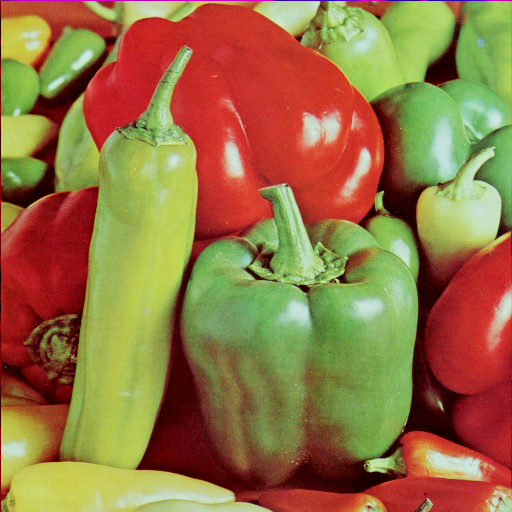

In [9]:
# Load image from disk.
img = Image.open(os.path.join(CHECKPOINT_PATH, "paprika.tiff"))

# Convert to torch tensor.
img_tensor = transforms.ToTensor()(img)


print(img_tensor.size())


img

Για να γίνει η αντιστοίχιση των πίξελ στην μετασχηματισμένη εικόνα, θα χρησιμοποιηθεί η συνάρτηση της PyTorch  : `grid_sample` [(Έγραφα)](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html).Μπορεί κάποιος να ανατρέξει στις οδηγίες που δίνονται για μια ολοκληρωμένη κατανόηση της συνάρτηση .
Ουσιαστικά, αυτή η συνάρτηση χρησιμοποιείται για τη δι-γραμμική και τρι-γραμμική παρεμβολή που χρειάζεται για να πάρουμε τα ανάλογα βάρη του πυρήνα.



In [10]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation.

    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, H, W] or [2, N, H, W]
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)




    # Grid_sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)
  


    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)



    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear"
    )

def trilinear_interpolation(signal, grid):
    """

    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [3, D, H, W] or [3, N, D, H, W]
    """
    # If signal or grid is a 4D array, add a dimension to support grid_sample.
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, D, H, W, 3] instead of [3, N, D, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)

    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)

    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear" # actually trilinear in this case...
    )


In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define a sample input image (1 batch, 1 channel, 3x3)
input_image = torch.tensor([[[[1, 2, 3],
                               [4, 5, 6],
                               [7, 8, 9]]]], dtype=torch.float32)

# Define a sample grid for bilinear interpolation
grid = torch.tensor([[[[-1, -1], [0, -1], [1, -1]],
                      [[-1,  0], [0,  0], [1,  0]],
                      [[-1,  1], [0,  1], [1,  1]]]], dtype=torch.float32)
reshaped_grid = grid.permute(0, 3, 1, 2).reshape(2, 3, 3)

# print(reshaped_grid.size())
# print(grid.size())

c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()
grid=c4.left_action_on_R2(g1, reshaped_grid)



intermediate_grid = grid.reshape(1, 2, 3, 3)

# Permute dimensions to get the original shape
original_shape_grid = intermediate_grid.permute(0, 2, 3, 1)
print(original_shape_grid.size())
# print(grid)

# # Perform bilinear interpolation using grid_sample
output_image = F.grid_sample(input_image, original_shape_grid, padding_mode='zeros', align_corners=True, mode='bilinear')

# # Print the input image, grid, and output image
print("Input Image:")
print(input_image)


print("\nOutput Image:")
print(output_image)

r = c4.elements()
t=[c4.left_action_on_R2(c4.inverse(i), reshaped_grid) for i in r ]
# print(t)
transformed_grid = torch.stack(t, dim=1)

print(transformed_grid)



transformed_grids = []
for element in c4.inverse(r):
    transformed_grids.append(
        c4.left_action_on_R2(element, reshaped_grid)
    )
transformed_grid = torch.stack(transformed_grids, dim=1)

print(transformed_grid)
#




torch.Size([2, 3, 3])
torch.Size([1, 3, 3, 2])
torch.Size([1, 3, 3, 2])
Input Image:
tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

Output Image:
tensor([[[[3.0000, 6.0000, 9.0000],
          [2.0000, 5.0000, 8.0000],
          [1.0000, 4.0000, 7.0000]]]])
tensor([[[[-1.0000e+00,  0.0000e+00,  1.0000e+00],
          [-1.0000e+00,  0.0000e+00,  1.0000e+00],
          [-1.0000e+00,  0.0000e+00,  1.0000e+00]],

         [[-1.0000e+00, -1.0000e+00, -1.0000e+00],
          [-1.1925e-08,  0.0000e+00,  1.1925e-08],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00]],

         [[ 1.0000e+00, -3.2584e-07, -1.0000e+00],
          [ 1.0000e+00,  0.0000e+00, -1.0000e+00],
          [ 1.0000e+00,  3.2584e-07, -1.0000e+00]],

         [[ 1.0000e+00,  1.0000e+00,  1.0000e+00],
          [ 1.6292e-07,  0.0000e+00, -1.6292e-07],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00]]],


        [[[-1.0000e+00, -1.0000e+00, -1.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0

In [12]:
# This creates a grid of the pixel locations in our image of [2, 512, 512] since
# our image is 2 dimensional and has a width and height of 512 pixels.
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))


# print(img_grid)

# Let's create the group of 90 degree clockwise rotations.
c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()



# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2.


g3 = c4.product(g1,g2)


print(img_grid.size())


t=c4.left_action_on_R2(c4.inverse(g3), img_grid)
print(t)
# print(t)
transformed_img = bilinear_interpolation(img_tensor, t)[0]
# print(transformed_img)
assert g3 == c4.elements()[-1]

torch.Size([2, 512, 512])
tensor([[[ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         [ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         [ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         ...,
         [ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         [ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         [ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9961, -0.9961, -0.9961,  ..., -0.9961, -0.9961, -0.9961],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         ...,
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
         [ 0.9961,  0.9961,  0.9961,  ...,  0.9961,  0.9961,  0.9961],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]])


In [13]:
# Transform the image grid we just created with the matrix representation of
# this group element.
transformed_img_grid = c4.left_action_on_R2(c4.inverse(g3), img_grid)

# Sample the image on the transformed grid points.
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]
print(transformed_img.size())

torch.Size([3, 512, 512])


In [14]:
# If we turn this back into a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img).save('paprika_rot.png', format='PNG')
# image.save('saved_image.png', format='PNG')


## 2. Ισοδύναμα Ομαδό-Συνελικτικά Δίκτυα

Όπως παρουσιάστηκε και στη θεωρία , τα κλασσικά ομαδο-συνελικτικά νευρωνικά δίκτυα αποτελούνται απο τρία κύρια στοιχεία-επίπεδα.Τα Lifting Convolution, Group convolution και Projection Operation. Παρουσιάζονται με τη σειρά.

### 2.1 Aνυψωτική Συνέλιξη

Πρώτη είναι η ανυψωτική συνέλιξη, η οποία διαχωρίζει χαρακτηριστικά σε οποιαδήποτε χωρική τοποθεσία στην είσοδο $f_{in}$ 
υπό μετασχηματισμούς της ομάδας $H$. Μπορεί να θεωρηθεί ως η καταγραφή σε όλο το χώρο ,για ένα χαρακτηριστικό $e$, για όλες τις 
μετασχηματισμένες εκδόσεις αυτού του χαρακτηριστικού  $\mathcal{L}_h(e)$, για $h \in H$.(Αντί για $\mathcal{L}_h(e)$ , μερικές φορές
γράφεται και $h \cdot e$, δηλώνοντας τη δράση του $h$ στο $e$). Η ανυψωτική συνέλιξη ,συνεπώς, χαρτογραφεί από το $\mathbb{R}^2$ προς το 
$G= \mathbb{R}^2 \rtimes H$.
Ως αποτέλεσμα, ο ανυψωμένος χάρτης χαρακτηριστικών 
$f_{out}$ έχει, εκτός από τις συνήθεις χωρικές διαστάσεις, μία ή περισσότερες πρόσθετες διαστάσεις ομάδας (ανάλογα με τη διαστατικότητα του $H$
).


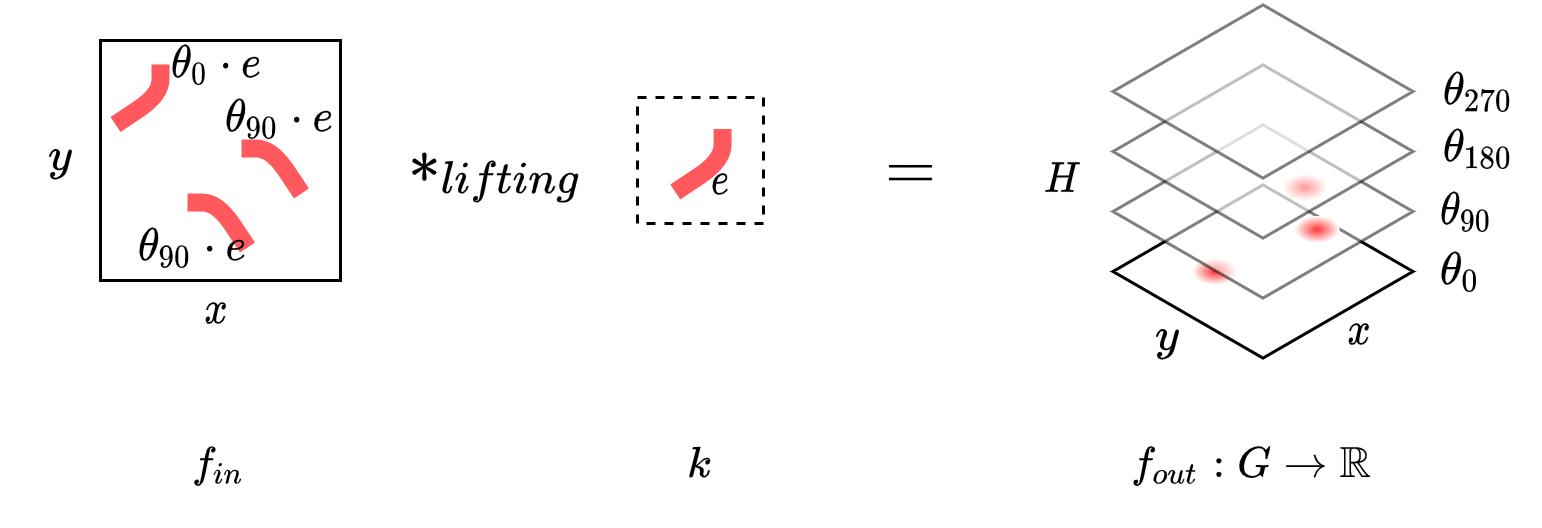

Για παράδειγμα ,αν χρησιμοποιηθεί η ομάδα περιστροφών κατα $90^{\circ}$
ως $H$,και το χαρακτηριστικό $e$ είναι ένα είδος καμπύλης, τότε μπορεί να υπάρχουν τρεις εμφανίσεις αυτού του 
χαρακτηριστικού στον χάρτη χαρακτηριστικών εισόδου $f_{in}$. 
Από αυτές, οι δύο μπορεί να βρίσκονται υπό περιστροφή  $90^{\circ}$, 
δηλαδή $\theta_{90}\cdot e$, και η μία χωρίς περιστροφή, δηλαδή $\theta_0 \cdot e$. 

Μια lifting convolution με έναν πυρήνα 
$k$
που ταιριάζει ακριβώς με το χαρακτηριστικό 
$e$ , θα καταλήξει σε αποκρίσεις με διαφορετικές μετατοπίσεις κατά 
μήκος της διάστασης της ομάδας στον χάρτη χαρακτηριστικών.
Συγκεκριμένα, θα υπάρξει μια απόκριση στον χωρικό χάρτη χαρακτηριστικών
που αντιστοιχεί στο στοιχείο της ομάδας
$\theta_0$ και δύο αποκρίσεις στον χωρικό χάρτη χαρακτηριστικών που αντιστοιχεί 
στο στοιχείο της ομάδας 
$\theta_{90}$.  Η παραπάνω εικόνα δίνει μια καλή διαίσθηση.


### 2.1.1 Σύνοψη

Με αυτή τη διαδικασία, 
η συνέλιξη εντοπίζει χαρακτηριστικά 
υπό διάφορους μετασχηματισμούς της ομάδας 
$H$, παρόμοια με την προσέγγιση που 
χρησιμοποιείται στα κλασικά CNN. Αυτή η μέθοδος 
επιτρέπει την εξαγωγή χαρακτηριστικών ανεξάρτητα από 
τη θέση τους, καθώς ο ίδιος πυρήνας εφαρμόζεται σε 
όλες τις χωρικές τοποθεσίες. Με αυτόν τον τρόπο, 
επιτυγχάνεται η γενίκευση της συνελικτικής διαδικασίας 
ώστε να είναι συμβατή με μετασχηματισμούς της ομάδας, 
ενισχύοντας την ικανότητα του δικτύου να αναγνωρίζει 
τα ίδια μοτίβα σε διαφορετικές γεωμετρικές παραλλαγές.

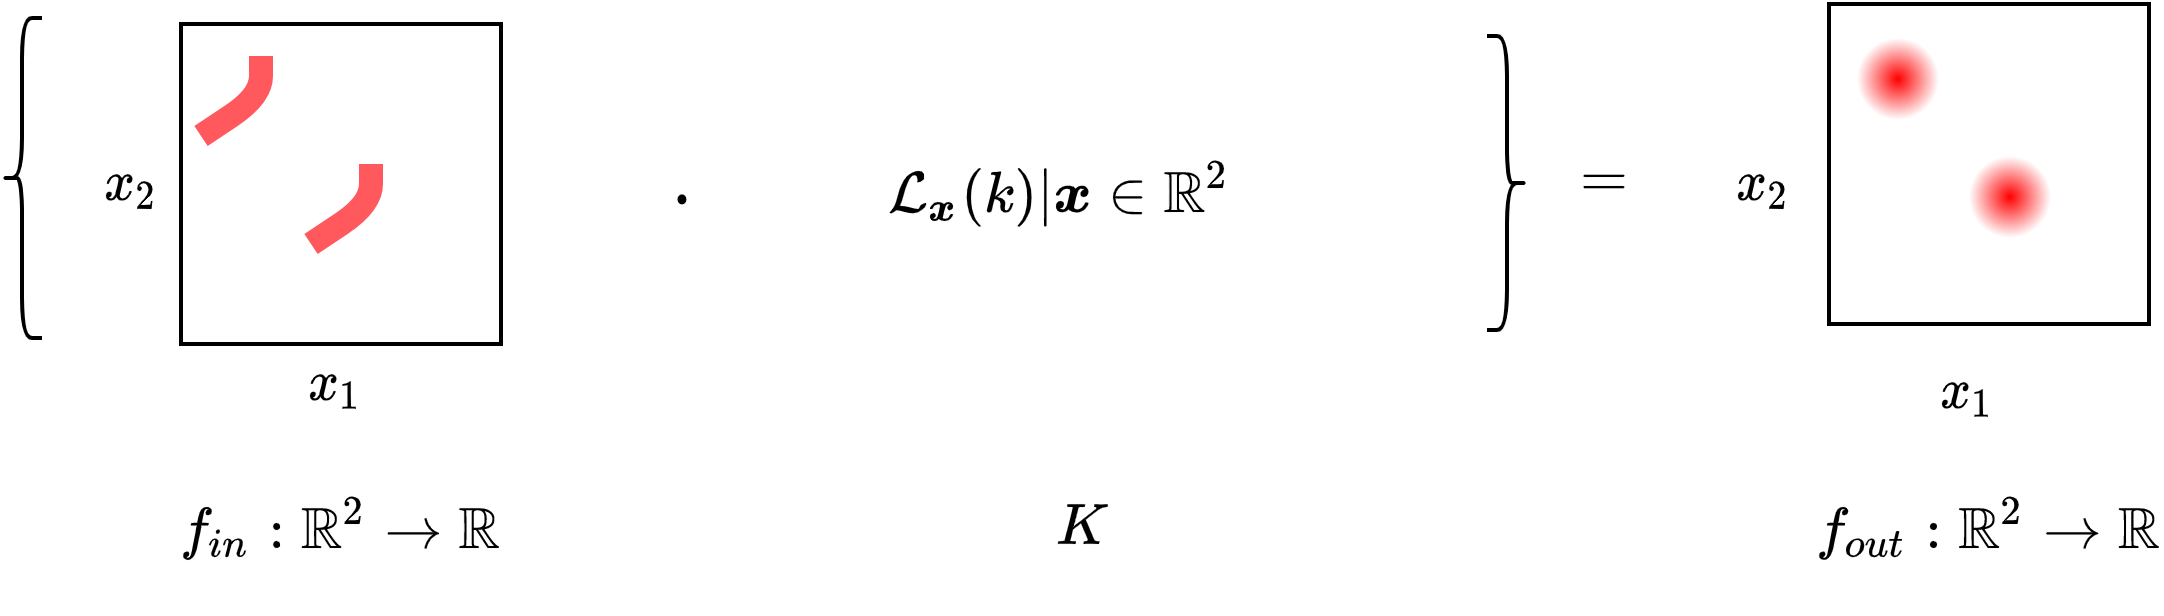

Σύμφωνα με τη θεωρία Ομάδων, η διαδικασία αυτή μπορεί να κατανοηθεί ως η εφαρμογή όλων των πιθανών μετατοπίσεων 
$\boldsymbol{x} \in \mathbb{R}^2$
στον πυρήνα 
$k$ και η καταγραφή της προκύπτουσας απόκρισης. Αυτή η απόκριση προκύπτει από τον 
υπολογισμό του εσωτερικού γινομένου της εισόδου 
$f_{in}$ με τον μετασχηματισμένο πυρήνα 
$\mathcal{L}_{\mathbf{x}} (k)$. Ουσιαστικά, η μετασχηματισμένη μορφή του πυρήνα 
$\mathcal{L}_{\mathbf{x}} (k)$ εφαρμόζεται σε κάθε σημείο 
της εισόδου, και το εσωτερικό γινόμενο αυτής της εφαρμογής παράγει την απόκριση.

Αυτή η πράξη διατηρεί τη διάσταση της εισόδου, δηλαδή ξεκινά με έναν χάρτη χαρακτηριστικών που ορίζεται στο 
$\mathbb{R}^2$
και παράγει επίσης έναν χάρτη χαρακτηριστικών ορισμένο στο 
$\mathbb{R}^2$. 
Με αυτό τον τρόπο, η συνελικτική πράξη ενσωματώνει πληροφορίες από 
το χώρο και τις μετατοπίσεις, ενώ τα χαρακτηριστικά που εξάγονται 
είναι συνεπή με τις μετασχηματιστικές ιδιότητες της ομάδας.


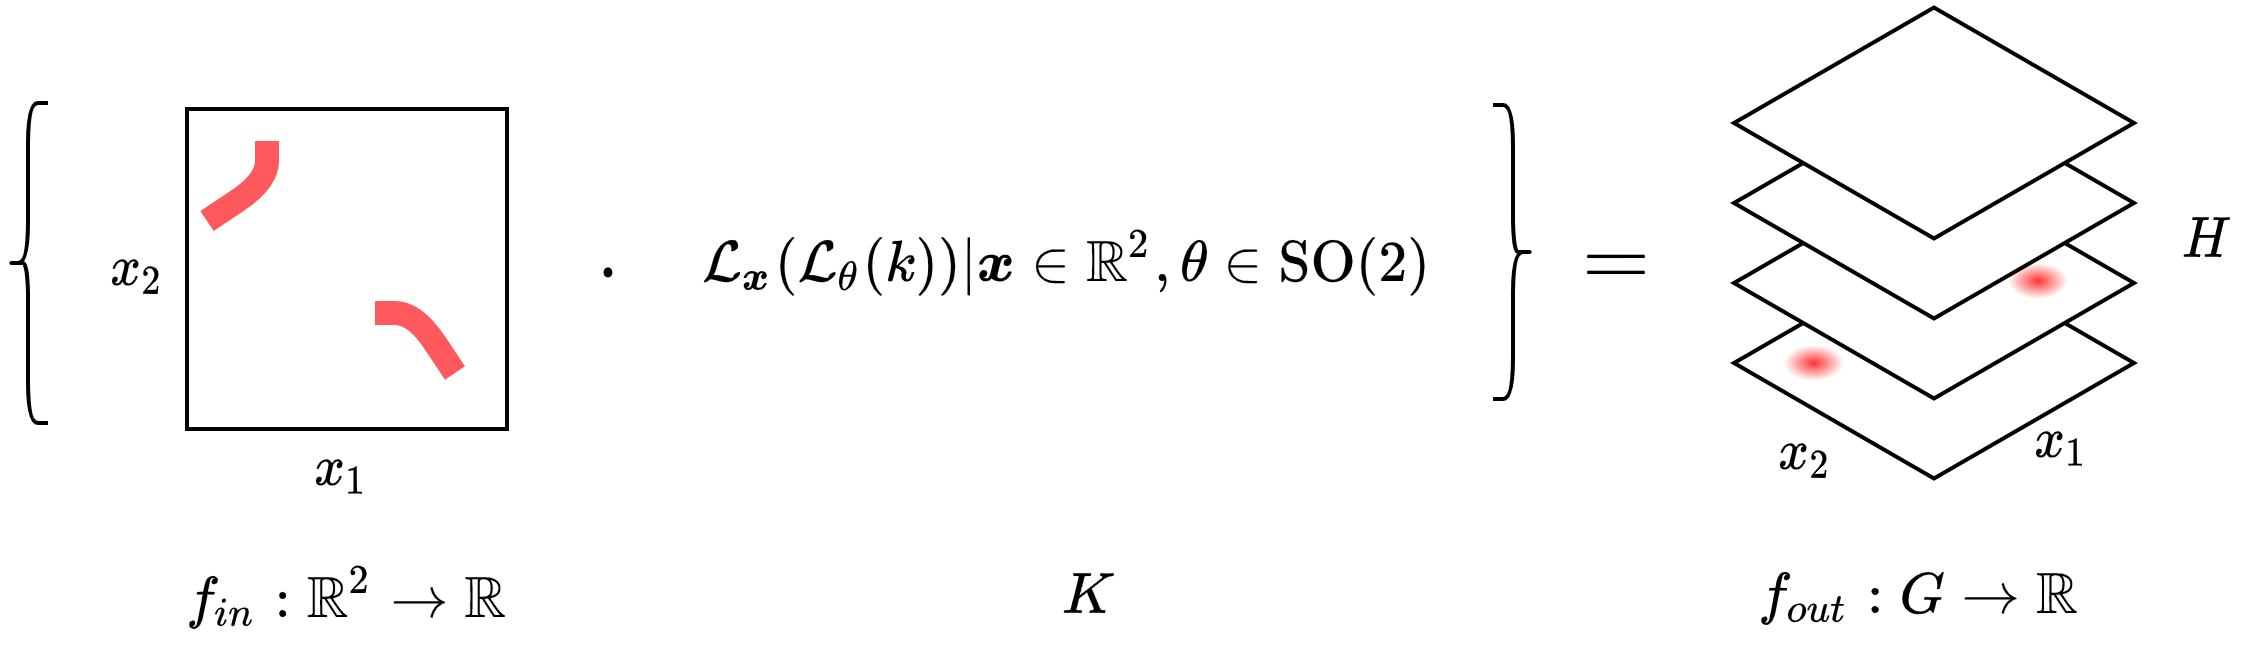

Στη συνέχεια , χρειάζεται επιπλέον να καταγραφούν χαρακτηριστικά υπό διαφορετικές δράσεις ομάδων $\mathcal{L}_h$ για $h \in H$.Αυτό μπορεί να επιτευχθεί μετασχηματίζοντας τον πυρήνα  $k$ με όλες τις δράσεις της ομάδας και καταγράφοντας τα αποτελέσματα. Για παράδειγμα, στο πλαίσιο της ομάδας περιστροφής 
${\rm C_4}$, δεν εξετάζεται μόνο η μετατόπιση, αλλά και η περιστροφή του πυρήνα 
$k$ κατά όλες τις δυνατές περιστροφές των $90^{\circ}$ και καταγράφονται οι  αποκρίσεις για τους προκύπτοντες μετασχηματισμένους πυρήνες!


#### 2.1.2 Υλοποίηση του πυρήνα Ανυψωτικής συνέλιξης

Πρώτα ,ορίζεται ένας πυρήνας $k$ , ο οποίο μετασχηματίζεται υπό αυθαίρετες δράσεις ομάδων με $\mathcal{L}_h$.Όταν χρησιμοποιούνται εικόνες για είσοδο, ένας
πυρήνας συνέλιξης χαρακτηρίζεται συνήθως ως μια συλλογή ανεξάρτητων δειγµατοληπτηµένων βαρών $W$ που δημιουργούνται πάνω σε μια ισαπέχουσα διακριτοποίηση του 
$\mathbb{R}^2$
  (τα εικονοστοιχεία (pixel) είναι ομοιόμορφα κατανεμημένα).

Υπενθυμίζεται ότι για να εκφραστεί η δράση της ομάδας $H$ σε συναρτήσεις (όπως οι πυρήνες $k$) που ορίζονται στο $\mathbb{R}^2$ μέσω της κανονικής αναπαράστασης $\mathcal{L}_h$.Η κανονική αναπαράσταση μετασχηματίζει τη συνάρτηση $k$ μέσω ενός μετασχηματισμού του πεδίου ορισμού της συνάρτησης 
$k$. Στην ουσία, η κανονική αναπαράσταση μετασχηματίζει το πλέγμα πάνω στο οποίο ορίζεται ο πυρήνας 
$k$, επιτρέποντάς  την εξαγωγή των τιμών για τη μετασχηματισμένη συνάρτηση 
$\mathcal{L}_h(k)$.

Ως εκ τούτου, για να οριστεί ένας πυρήνας $k$ ,ο οποίος μπορεί να μετασχηματιστεί με την κανονική αναπαράσταση της ομάδας $H$, πρέπει 
να κατασκευαστεί ένα πλέγμα (grid) πάνω στο οποίο ορίζονται οι τιμές του πυρήνα. Στη συνέχεια ,το πλέγμα αυτό μετασχηματίζεται με τη δράση κάθε στοιχείου της ομάδας $h \in H$ για να εξαχθεί ένα σύνολο πλεγμάτων που αντιστοιχούν στους μετασχηματισμένους πυρήνες για κάθε στοιχείο της ομάδας $H$.



Σημείωση:
* Στην υλοποίηση των πράξεων ανύψωσης και συνέλιξης ομάδας, θα χρησιμοποιηθεί η κλαση `Conv2D` της PyTorch. Αυτό θα απλοποιήσει αρκετά τον τρόπο μεταφοράς των πυρήνων $k$ σε όλες τις θέσεις της εισόδου. Συνεπώς, δεν χρειάζεται η κατασκευή της δράσης της ομάδας μεταφοράς ($\mathcal{L}_{\mathbf{x}}$), αλλά ακόμα θα υπάρχει η ισοδυναμία προς αυτή. Απλώς είναι αναγκαία η προσαρμογή των πράξεων για να είναι συμβατές με την `Conv2D`.



In [15]:
c4 = CyclicGroup(order=4)
r = c4.elements()


t=[c4.left_action_on_R2(i, img_grid) for i in r ]
print(t[0])
print(len(t))
print(type(t))


transformed_grid = torch.stack(t, dim=1)
transformed_grid.size()
print(transformed_grid.size())


print(r.numel())


tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9961, -0.9961, -0.9961,  ..., -0.9961, -0.9961, -0.9961],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         ...,
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
         [ 0.9961,  0.9961,  0.9961,  ...,  0.9961,  0.9961,  0.9961],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         ...,
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000]]])
4
<class 'list'>
torch.Size([2, 4, 512, 512])
4


In [16]:
class LiftingKernelBase(torch.nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements a base class for the lifting kernel. Stores the R^2 grid
        over which the lifting kernel is defined and it's transformed copies
        under the action of a group H.

        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create spatial kernel grid. These are the coordinates on which our
        # kernel weights are defined.
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # Transform the grid by the elements in this group.
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.

        """
        # Obtain all group elements.

        
        group_elements = self.group.elements()
        

        # Transform the grid defined over R2 with the sampled group elements.
        # Recall how the left-regular representation acts on the domain of a
        # function on R2! (Hint: look closely at the equation given under 1.3)
        # We'd like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].
        # |H| is the elements of the group

       
        transformed_grids = [self.group.left_action_on_R2(self.group.inverse(group_element), self.grid_R2) for group_element in group_elements ]
        transformed_grid = torch.stack(transformed_grids, dim=1)
        

        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()


In [17]:
# Let's check whether our implementation works correctly. First we inspect the
# shape of our transformed grids to assess whether this is correct.
order = 4
lifting_kernel_base = LiftingKernelBase(
    group=CyclicGroup(order=order),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

# The grid has a shape of [2, |H|, kernel_size, kernel_size].
assert lifting_kernel_base.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

print(lifting_kernel_base.transformed_grid_R2.shape)

torch.Size([2, 4, 7, 7])


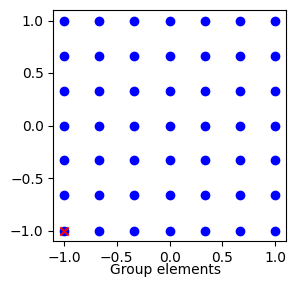

In [18]:
plt.rcParams['figure.figsize'] = [3, 3]
transformed_grid_R2 = lifting_kernel_base.transformed_grid_R2

# Create [group_elements] figures
fig, ax = plt.subplots(1, 1)

ax.scatter(
    transformed_grid_R2[1,0, :, :],
    transformed_grid_R2[0,0, :, :],
    c='b'
)

ax.scatter(
    transformed_grid_R2[1, 0, 0, 0],
    transformed_grid_R2[0, 0, 0, 0],
    marker='x',
    c='r'
)



fig.text(0.5, 0., 'Group elements', ha='center')
plt.show()

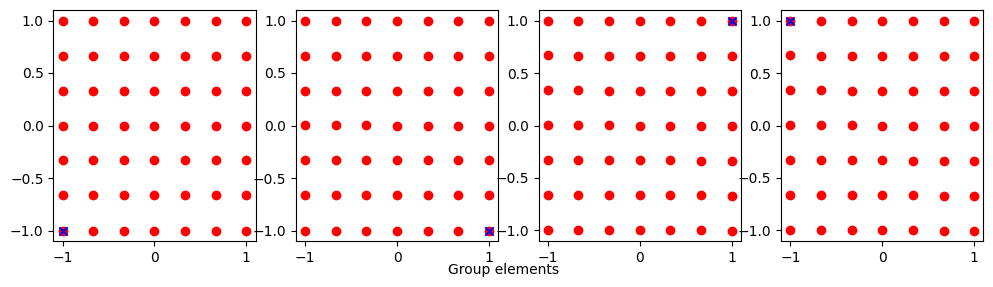

In [19]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, order)

# Get the grid
transformed_grid_R2 = lifting_kernel_base.transformed_grid_R2

# Visualize the transformed kernel grids. We mark the same cornerpoint by a
# blue 'x' in all grids as reference point.
for group_elem in range(order):
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, :, :],
        transformed_grid_R2[0, group_elem, :, :],
        c='r'
    )
    # Mark a corner point so we can see it transform.
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, 0, 0],
        transformed_grid_R2[0, group_elem, 0, 0],
        marker='x',
        c='b'
    )

fig.text(0.5, 0., 'Group elements', ha='center')
plt.show()

Εδώ φαίνεται η αριστερόστροφη περιστροφή εφαρμόζοντας τη δράση ομάδας

Έχοντας δημιουργήσει ένα σύνολο από μετασχηματισμένα πλέγματα υπό τη δράση της ομάδας $H$.Χρειάζεται να δειγματοληπτήσουμε τις τιμές του πυρήνα στα σημεία του πλέγματος σε καθένα από αυτά τα πλέγματα.
Αυτό είναι έαν μεγάλο εμπόδιο στην εφαρμογή των GCNNs.

Ενώ στα συμβατά CNNs χρησιμοποιούνται το ίδιο σύνολο βαρών σε όλες τις χωρικές θέσεις ,κάτι το οποίο οφείλεται στο γεγονός ότι ο πυρήνας μετακινείται μόνο με βήματα που αντιστοιχούν σε αποστάσεις ολόκληρων εικονοστοιχείων (pixel). Για αυθαίρετες ομάδες $H$ ,όμως  ενδέχεται να απαιτούνται τιμές πυρήνα για σημεία πλέγματος που βρίσκονται εκτός του πλέγματος των εικονοστοιχείων του πυρήνα υπό τον κανονικό του μετασχηματισμό.

Για την επίλυση αυτού του ζητήματος θα χρησιμοποιηθεί η διαδικασία της παρεμβολής έτσι ώστε να ληφθούν οι τιμές πυρήνα ανάμεσα στις θέσεις του πλέγματος και αυτών των εικονοστοιχείων.Αυτό βέβαια δημιουργεί πρόβλημα στην εκφραστικό ,εισάγοντας θόρυβο λόγω παρεμβολής (interpolation artifacts).  

Σημείωση:

* Όταν υλοποιείται η ισοδυναμία για τη ομάδα περιστροφών κατά $90^{\circ}$,$H=C_4$, είναι δυνατό να αποφευχθεί η χρήση παρεμβολής,καθώς όλα τα μετασχηματισμένα πλέγματα μοιράζονται τις ίδιες θέσεις.Άρα η υλοποίηση της δράσης ομάδας γι αυτή τη συγκεκριμένη ομάδα θα μπορούσε να γίνει μέσω μιας μετάθεσης των βαρών.Παρόλα αυτά, η υλοποίηση θα γίνει σε ένα πιο γενικό πλαίσιο,γι αυτό και θα γίνει η χρήση της παρεμβολής.Η δειγματοληψία μιας εισόδου σε ένα πλέγμα γίνεται μέσω της PyTorch με τη συνάρτηση `grid_sample` που θα βοηθήσει στην διαδικασία της παρεμβολής.


In [20]:
wei=torch.nn.Parameter(torch.zeros((
            1,
            2,
           7,
            7
        )))

print(t)

        # Initialize weights using kaiming uniform intialisation.
kai= torch.nn.init.kaiming_uniform_(wei, a=math.sqrt(5))

print(kai)


weight = wei.view(
        1 * 2,
        7,
       7
)

print(weight)




wei=torch.nn.Parameter(torch.zeros((
            1*2,
           7,
            7
        )))
kai= torch.nn.init.kaiming_uniform_(wei, a=math.sqrt(5))
print(kai)


[tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9961, -0.9961, -0.9961,  ..., -0.9961, -0.9961, -0.9961],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         ...,
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
         [ 0.9961,  0.9961,  0.9961,  ...,  0.9961,  0.9961,  0.9961],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         ...,
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000],
         [-1.0000, -0.9961, -0.9922,  ...,  0.9922,  0.9961,  1.0000]]]), tensor([[[ 1.0000,  0.9961,  0.9922,  ..., -0.9922, -0.9961, -1.0000],
         [ 1.0000,  0.9961,  0.9922,  ..., 

In [21]:
t=torch.nn.Parameter(torch.zeros((
            1,
           3,
            4,
            4
        )))

print(t)
print(t.size())

Parameter containing:
tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]], requires_grad=True)
torch.Size([1, 3, 4, 4])


In [22]:
class InterpolativeLiftingKernel(LiftingKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # Create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels.
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # Initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        # First, we fold the output channel dim into the input channel dim;
        # this allows us to transform the entire filter bank in one go using the
        # torch grid_sample function.

        
        weight = self.weight.view(
            self.out_channels*self.in_channels,
            self.kernel_size,
            self.kernel_size

        )
       

        # Sample the transformed kernels.
        # ousiastika edw pairnoume ta kernels-weight kai ta kanoume rotation
        transformed_weight = []
        for spatial_grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                bilinear_interpolation(weight, self.transformed_grid_R2[:, spatial_grid_idx, :, :])
            )
        # print(len(transformed_weight))
        transformed_weight = torch.stack(transformed_weight)
        # print(transformed_weight.size())

        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        # print(transformed_weight.size())


        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [23]:
ik = InterpolativeLiftingKernel(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=2,
    out_channels=1
)

weights = ik.sample()
weights.shape

torch.Size([1, 4, 2, 7, 7])

Απεικόνιση των βαρών που εξάχθηκαν από τον ανυψωτικο συνελικτικό πυρήνα.

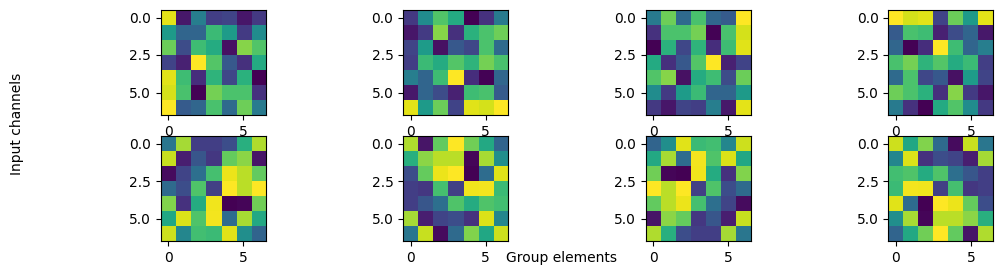

In [24]:
# Pick an output channel to visualize
out_channel_idx = 0

# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(ik.in_channels, ik.group.elements().numel())

for in_channel in range(ik.in_channels):
    for group_elem in range(ik.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

#### 2.1.3 Υλοποίηση Ανυψωτικής Συνέλιξης

Τελικά, δημιουργείται η λειτουργία της ανυψωτικής συνέλιξης. Αυτή η
κλάση έχει σχεδιαστεί για να δέχεται έναν χάρτη χαρακτηριστικών ορισμένο στο $\mathbb{R}^2$
και παράγει ένα χάρτη χαρακτηριστικών στο $\mathbb{R}^2\rtimes H$,όπου τα χαρακτηριστικά υπο διαφορετικούς μετασχηματισμούς $h \in H$ βρίσκονται κατα μήκος του άξονα $H$.

Σημείωση:
* Για αποφευχθεί η ανάγκη υλοποίησης της συνέλιξης από την αρχή αξιοποιείται η βελτιστοποιημένη κλάση `Conv2D` της PyTorch,κάνοντας μικρές αλλαγές.
Κανονικά, ένα επίπεδο συνέλιξης εφαρμόζει ένα σύνολο από 
$n$ χωρικούς πυρήνες σε όλη την είσοδο, όπου 
$n$ είναι ο αριθμός των καναλιών εξόδου της λειτουργίας συνέλιξης.
Όμως, τώρα υπάρχουν `num_group_elem` μετασχηματισμένες εκδόσεις
αυτών των πυρήνων , τις οποίες θέλουμε να εφαρμόσουμε παντού στην είσοδο .Γι αυτό και αντιμετωπίζουμε κάθε μετασχηματισμό του ίδιου χωρικού πυρήνα ως ξεχωριστό κανάλι εξόδου.Για να γίνει αυτό χρειάζεται απλώς να αναδιαμορφωθεί το σύνολο των πυρήνων από 
`[out_channels, num_group_elem, in_channels, kernel_size, kernel_size]` σε ένα σύνολο πυρήνων `[out_channels x num_group_elem, in_channels, kernel_size, kernel_size]`.
* Όπως αναφέρθηκε, ένα εξαιρετικό πρόσθετο πλεονέκτημα της χρήσης της κλάσης `Conv2D` της PyTorch είναι ότι δεν απαιτείται να υπολογιστούν οι μετατοπισμένοι πυρήνες 
$\mathcal{L}_{\mathbf{x}}(k)$.



In [25]:
class LiftingConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel = InterpolativeLiftingKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )

        self.padding = padding

    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, spatial_dim_1,
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
            spatial_dim_2]
        """

        # Obtain convolution kernels transformed under the group.

        
        conv_kernels = self.kernel.sample()
        

        # Apply lifting convolution. Note that using a reshape we can fold the
        # group dimension of the kernel into the output channel dimension. We
        # treat every transformed kernel as an additional output channel. This
        # way we can use pytorch's conv2d function!


        
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                                self.kernel.out_channels*self.kernel.group.elements().numel(),
                                self.kernel.in_channels,
                                self.kernel.kernel_size,
                                self.kernel.kernel_size),
                                
            padding=self.padding
        )
        

   

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1,
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements,
        # spatial_dim_1, spatial_dim_2], separating channel and group
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )




        return x


In [26]:
# With square kernels and equal stride
filters = torch.randn(32, 3, 5, 5)
inputs = torch.randn(1,3, 7, 7)
# F.conv2d(inputs, filters, padding=0)



x = torch.nn.functional.conv2d(
            input=inputs,
            weight=filters,            
            padding=0
        )

In [27]:
lifting_conv = LiftingConvolution(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=1,
    out_channels=16,
    padding=0
)


input_tensor = torch.randn(1, 1, 28, 28)  # Batch size 1, 3 input channels, 32x32 spatial dimensions

# # Define convolution kernels
# conv_kernels = torch.randn(6, 3, 5, 5)  # 6 output channels, 3 input channels, 5x5 kernel size

# # Perform convolution
# output_tensor = torch.nn.functional.conv2d(input=input_tensor, weight=conv_kernels, padding=2)


output_tensor=lifting_conv.forward(input_tensor)
print(output_tensor)

torch.Size([16, 4, 1, 5, 5])
torch.Size([1, 64, 24, 24])
torch.Size([1, 16, 4, 24, 24])
tensor([[[[[-1.6904e-02, -1.0334e-01,  3.0653e-01,  ...,  4.6354e-01,
             2.2745e-01, -7.2192e-01],
           [ 9.4938e-02,  4.0783e-01, -1.5460e-01,  ..., -2.8486e-02,
            -4.5698e-01,  2.2315e-01],
           [-2.6134e-01, -1.0406e-01, -6.6670e-01,  ..., -4.7820e-01,
             2.5643e-01, -4.7343e-01],
           ...,
           [ 5.1084e-01,  5.5269e-02, -8.4307e-02,  ...,  7.6473e-02,
             7.5669e-01,  2.5798e-01],
           [ 2.9826e-01, -1.6297e-01, -5.5930e-01,  ...,  6.8892e-02,
             1.1990e+00,  8.3319e-02],
           [ 6.8959e-03,  2.4375e-01,  4.7278e-02,  ...,  1.0636e+00,
            -1.9704e-01,  1.3707e-02]],

          [[-4.7645e-01, -9.2858e-01, -3.3944e-01,  ..., -2.4902e-01,
            -3.1917e-01, -7.6789e-01],
           [-1.1336e-01, -9.4255e-01, -6.9036e-01,  ..., -7.4119e-01,
            -3.1805e-01, -2.3662e-02],
           [-4.5263e-0

### 2.2 Συνέλιξη Ομάδας

Τώρα,που έχει δημιουργηθεί ένας τρόπος να αποκτηθούν χάρτες χαρακτηριστικών ορισμένους πάνω στην ομάδα $G$ από συναρτήσεις εισόδου ορισμένες στο $\mathbb{R}^2$ (εικόνες) ,μπορεί να υλοποιηθεί ένα επίπεδο συνέλιξης που λειτουργεί πλήρως στην ομάδα
$G: \mathbb{R}^2 \rtimes H$. Σημειωνέται, ότι ο χάρτης χαρακτηριστικών εισόδου σε αυτο το στάδιο,$f_{in}$ έχει, πέρα από τις συνήθεις χωρικές διαστάσεις ορισμένες στο $\mathbb{R}^2$,
μία ή περισσότερες επιπλέον διαστάσεις ομάδας ορισμένες στο $H$.
Ως εκ τούτου η λειτουργία συνέλιξης της ομάδας, $*_{group}$, αντιστοιχεί μια συνάρτηση $f_{in}$ της ομάδα ,σε μία άλλη συνάρτηση $f_{out}$ που ορίζεται και αυτή στην ίδια ομάδα .




#### 2.2.1 Σύνοψη 

Καθώς  η είσοδος στο επίπεδο συνέλιξης ομάδας περιλαμβάνει πλέον πρόσθετες διαστάσεις ομάδας,$f_{in}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$. Συνεπώς, η συνέλιξη πρέπει να εκτελεστεί χρησιμοποιώντας έναν πυρήνα
$k_{group}$  που ορίζεται επίσης σε ολόκληρη την ομάδα,συγκεκριμένα  
$k_{group}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$.
Αυτό διαφέρει από τη συνέλιξη ανύψωσης, όπου ο πυρήνας 
$k_{lifting}$
που ορίζεται αποκλειστικά εντός του χωρικού τομέα
$\mathbb{R}^2$. Αυτό ο πυρήνας $k_{group}$ μπορεί να θεωρηθεί ως μία στοίβα χωρικών πυρήνων, μία για κάθε ξεχωριστό στοιχείο της ομάδας $h \in H$. Σημαντικό είναι ότι, δεδομένου ότι ο 
$k$είναι τώρα επίσης ορισμένος πάνω σε ένα πλέγμα πάνω από το 
$Η$, η ομάδα 
$Η$τώρα έχει επίσης μια δράση πάνω σε αυτόν τον άξονα 
$Η$ του 
$k$.Για παράδειγμα,στην περίπτωση της ομάδας $H=C_4$, τα στοιχεία 
$\theta \in C_4$ δεν έχουν μόνο περιστροφική δράση στον χωρικό τομέα του πυρήνα, αλλά και μια μεταφορική δράση κατά μήκος του άξονα της ομάδας.Έτσι, η εφαρμογή ενός στοιχείου της ομάδας
$\theta \in C_4$ έχει ως αποτέλεσμα μια συνδυαστική λογική  περιστροφικής μεταφορικής μετατόπιση του $k$ κατά μήκος του άξονα της ομάδας. 




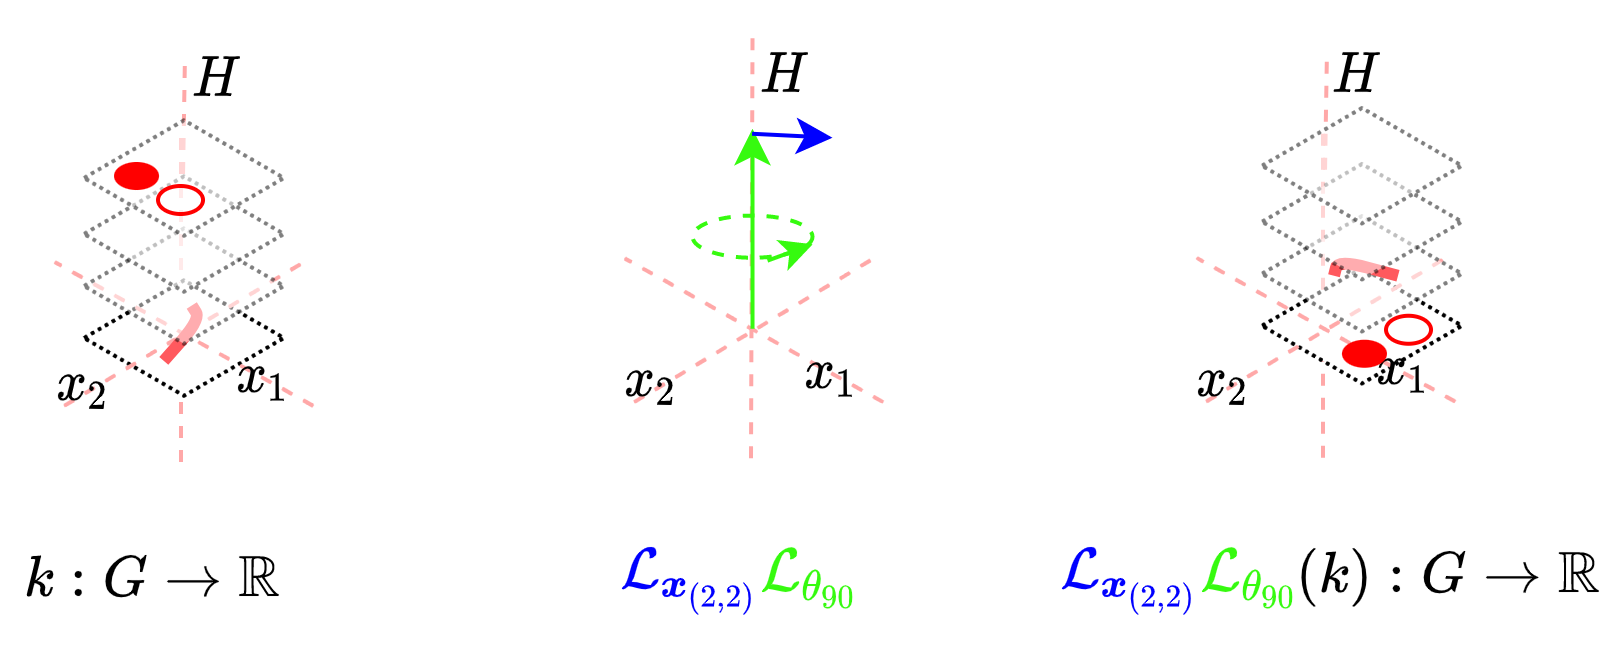


Εκτός από την προαναφερθείσα  διαφορά, ο τελεστής συνέλιξης ομάδας λειτουργεί με τον ίδιο τρόπο όπως ο τελεστης ανύψωσης. O πυρήνας $k_{group}$
 μετασχηματίζεται μέσω των ενεργειών των ομάδων $H$ και $\mathbb{R}^2$ και λαμβάνονται οι αποκρίσεις  από το εσωτερικό γινόμενο αυτού του πυρήνα με την είσοδο.
 Σημειώνεται, ότι πάλι για τη δράση της ομάδας μεταφοράς χρησιμοποιείται η συνάρτηση της PyTorch.



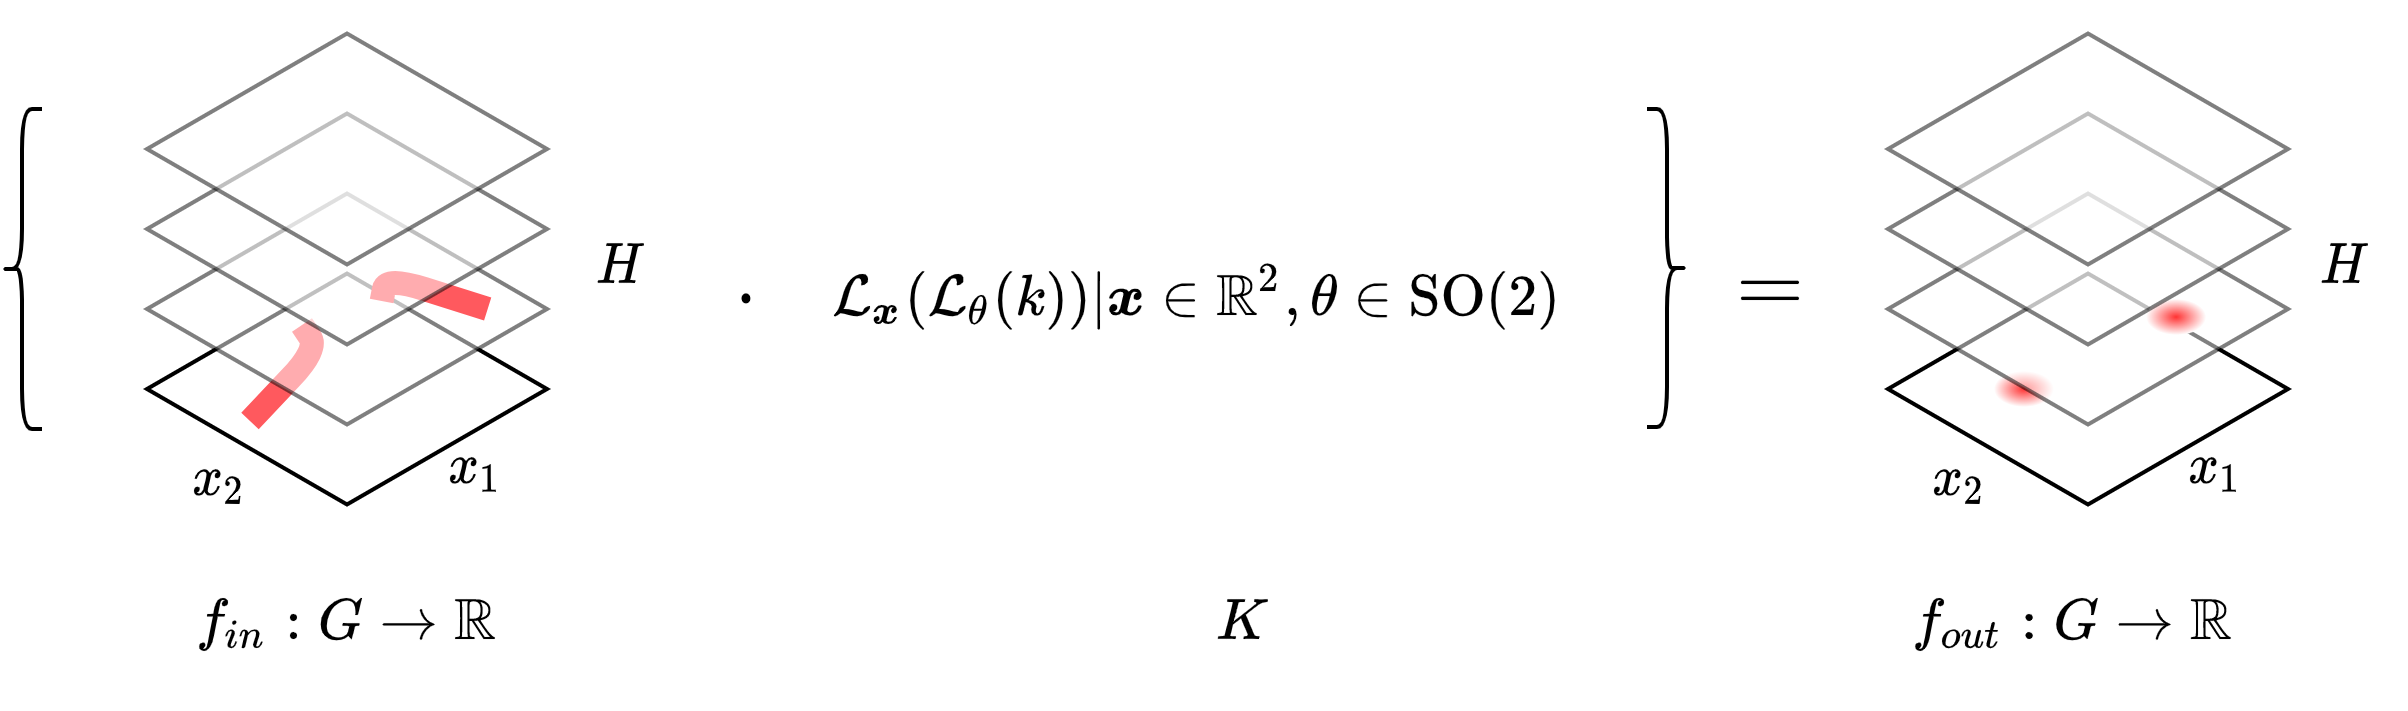

#### 2.2.2 Υλοποίηση του πυρήνα Συνέλιξης Ομάδας

Για άλλη μια φορά, είναι σημαντικό να οριστεί ο πυρήνας $k$ ,ο οποίος μετασχηματίζεται από την δράση ομάδας.Τώρα, όμως το πλέγμα του πυρήνα ορίζεται εκτός απο το $\mathbb{R}^2$, αλλα επιπλέον και στο $H$.

Σημειώσεις:

* Δεδομένου ότι το πλέγμα πάνω στο $H$ αποτελείται από στοιχεία $h'\in H$, ο μετασχηματισμός πλέγματος πάνω στο $H$ με ,ένα άλλο, στοιχείο της ομάδας $h \in H$ ισοδυναμεί με την εφαρμογή του γινομένου ομάδας του $h$ με κάθε στοιχείο του πλέγματος  $h'$.
* Επειδή οι ομάδες που χρησιμοποιούνται είναι ημιευθύ γινόμενο, $\mathbb{R}^2 \rtimes H$, οι διαστάσεις $\mathbb{R}^2$ και $H$ μπορούν να μετασχηματιστούν ανεξάρτητα  ,πριν συνδυαστούν σε ένα κοινό πλέγμα πάνω στο $\mathbb{R}^2 \rtimes H$.


In [28]:
c4=CyclicGroup(order=4)
print(c4.elements())
group_elem=c4.elements()

transformed_grid_H = []
for g_inverse in c4.inverse(group_elem):
    transformed_grid_H.append(
        c4.product(
            g_inverse,group_elem
        )
    )

print(transformed_grid_H)

transformed_grid_H = torch.stack(transformed_grid_H, dim=1)
print(transformed_grid_H)

transformed_grid_H = c4.normalize_group_elements(transformed_grid_H)
print(transformed_grid_H)




tensor([0.0000, 1.5708, 3.1416, 4.7124])
[tensor([0.0000, 1.5708, 3.1416, 4.7124]), tensor([4.7124, 0.0000, 1.5708, 3.1416]), tensor([3.1416, 4.7124, 0.0000, 1.5708]), tensor([1.5708, 3.1416, 4.7124, 0.0000])]
tensor([[0.0000, 4.7124, 3.1416, 1.5708],
        [1.5708, 0.0000, 4.7124, 3.1416],
        [3.1416, 1.5708, 0.0000, 4.7124],
        [4.7124, 3.1416, 1.5708, 0.0000]])
tensor([[-1.0000,  1.0000,  0.3333, -0.3333],
        [-0.3333, -1.0000,  1.0000,  0.3333],
        [ 0.3333, -0.3333, -1.0000,  1.0000],
        [ 1.0000,  0.3333, -0.3333, -1.0000]])


In [29]:
class GroupKernelBase(torch.nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements base class for the group convolution kernel. Stores grid
        defined over the group R^2 \rtimes H and it's transformed copies under
        all elements of the group H.

        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create a spatial kernel grid
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # The kernel grid now also extends over the group H, as our input
        # feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())

    def create_transformed_grid_R2xH(self):
        """Transform the created grid over R^2 \rtimes H by the group action of
        each group element in H.

        This yields a set of grids over the group. In other words, a list of
        grids, each index of which is the original grid over G transformed by
        a corresponding group element in H.
        """
        # Sample the group H.

        
        group_elements = self.group.elements()
        

        # Transform the grid defined over R2 with the sampled group elements.
        # We again would like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].

       
        transformed_grid_R2 = []
        for g_inverse in self.group.inverse(group_elements):
            transformed_grid_R2.append(
                self.group.left_action_on_R2(g_inverse, self.grid_R2)
            )
        transformed_grid_R2 = torch.stack(transformed_grid_R2, dim=1)
        

        # Transform the grid defined over H with the sampled group elements. We want a grid of
        # shape [|H|, |H|]. Make sure to stack the transformed like above (over the 1st dim).

        

        transformed_grid_H = []
        for g_inverse in self.group.inverse(group_elements):
            transformed_grid_H.append(
                self.group.product(
                    g_inverse,self.grid_H
                )
            )

        # print(transformed_grid_H)
        # print(self.grid_H)

        transformed_grid_H = torch.stack(transformed_grid_H, dim=1)

        # print(transformed_grid_H)

        # print(transformed_grid_H)
        

        # Rescale values to between -1 and 1, we do this to please the torch
        # grid_sample function.
        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)


        # print(transformed_grid_H)

       


        # Create a combined grid as the product of the grids over R2 and H
        # repeat R2 along the group dimension, and repeat H along the spatial dimension
        # to create a [3, |H|, |H|, kernel_size, kernel_size] grid
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    2,
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                ).repeat(1, 1, group_elements.numel(), 1, 1),
                transformed_grid_H.view(
                    1,
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                ).repeat(1, 1, 1, self.kernel_size, self.kernel_size)
            ),
            dim=0
        )


        # print(transformed_grid)
        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()

Στην παρούσα σχεδίαση, το $H$ είναι μονοδιάστατο , και όπως παρατηρείται ο μετασχηματισμός του πλέγματος πάνω στο $H$ με όλα τα στοιχεία της ομάδας $H$,οδηγεί σε μία μεταφορά πάνω στην ομάδα. Στη συνέχεια αναλύεται το τι συμβαίνει οταν συνδυαστούν αυτά τα πλέγματα.

In [30]:
gk_base = GroupKernelBase(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=1,
    out_channels=1
)

gk_base.transformed_grid_R2xH.shape

torch.Size([3, 4, 4, 7, 7])

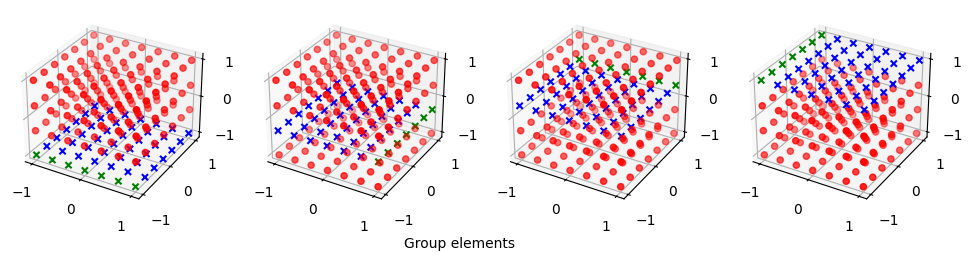

In [32]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures.
fig, ax = plt.subplots(
    1,
    gk_base.group.elements().numel(),
    subplot_kw=dict(projection='3d')
)

# Flatten spatial and group grid dimensions.
transformed_grid_R2xH = gk_base.transformed_grid_R2xH.reshape(
    3,
    gk_base.group.elements().numel(),
    gk_base.group.elements().numel() * gk_base.kernel_size * gk_base.kernel_size
)

# print(transformed_grid_R2xH.size())
# print(transformed_grid_R2xH[1, group_elem, 6:].size())

# Visualize the transformed kernel grids. We mark the same row by a blue 'x' in all grids as reference point.
for group_elem in range(gk_base.group.elements().numel()):
# for group_elem in range(1):
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 49:],
                           transformed_grid_R2xH[0, group_elem, 49:],
                           transformed_grid_R2xH[2, group_elem, 49:],
                           c='r')
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 7:49],
                           transformed_grid_R2xH[0, group_elem, 7:49],
                           transformed_grid_R2xH[2, group_elem, 7:49],
                           marker='x',
                           c='b',alpha=1)
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 0:7],
                           transformed_grid_R2xH[0, group_elem, 0:7],
                           transformed_grid_R2xH[2, group_elem, 0:7],
                           marker='x',
                           c='g',alpha=1)

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

Όπως παρατηρείται,το πλέγμα που ορίζεται πάνω στο  $\mathbb{R}^2 \rtimes H$,
παρουσιάζει περιστροφή πάνω στις χωρικές διαστάσεις και μετατόπιση κατά μήκος της διάστασης της,όταν τα στοιχεία της ομάδας $h' \in H$
εφαρμόζονται πάνω του.

Στη συνέχεια, θα ακολουθήσει η υλοποίηση του πυρήνα της ομάδας χρησιμοποιώντας και παρεμβολή.

Σημειώσεις:
* Για πολυδιάστατες ομάδες 
$H$, η ακόλουθη υλοποίηση δεν θα λειτουργούσε , καθώς αυτό θα απαιτούσε πυρήνες ορισμένους σε πλέγματα με διάσταση μεγαλύτερης από τρία, κάτι που η υλοποίηση της τρι-γραμμικής παρεμβολής με το 
`grid_sample` δεν υποστηρίζεται.
  Mια εναλλακτική προσέγγιση θα μπορούσε να περιλαμβάνει την υλοποίηση της δειγματοληψίας των βαρών κατά μήκος της διάστασης 
$H$ χρησιμοποιώντας μια μετατόπιση του πίνακα βαρών κατά μήκος των διαστάσεων της.
$H$, και μόνο να παρεμβάλλει πάνω στις χωρικές διαστάσεις.
* Η ομάδα $C_4$ παρουσιάζει περιοδικότητα κατά μήκος του άξονα της ομάδας,οπότε οι πυρήνες που υλοποιούνται,θα πρέπει να το λαμβάνουν υπόψη. Αν και υλοποιήθηκε σωστά το γινόμενο της ομάδας για να αντικατοπτρίζει αυτό ,το `grid_sample` δεν γνωρίζει την περιοδικότητα των βαρών στην παρεμβολή του. Αυτό δεν θα έπρεπε να είναι πρόβλημα, αφού, λόγω του περιορισμού κλειστότητας διασφαλίζεται ότι οι υπολογισμοί καταλήγουν ακριβώς πάνω σε σημεία του πλέγματος κατα μήκος του άξονα της ομάδας,εξαλείφοντας έτσι την ανάγκη παρεμβολής προς αυτή την κατεύθυνση.
Ωστόσο, είναι πιθανό να προκύψει στην πράξη κάποιος θόρυβος παρεμβολής λόγω της συγκεκριμένης εφαρμογής του `grid_sample`.


In [32]:
class  InterpolativeGroupKernel(GroupKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels. Note that our weight
        # now also extends over the group H.

      
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # this is different from the lifting convolution
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))
       

        # initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        # First, we fold the output channel dim into the input channel dim;
        # this allows us to transform the entire filter bank in one go using the
        # interpolation function.

        
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )
        

        transformed_weight = []
        # We loop over all group elements and retrieve weight values for
        # the corresponding transformed grids over R2xH.
        for grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                trilinear_interpolation(weight, self.transformed_grid_R2xH[:, grid_idx, :, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)

        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [33]:
igk = InterpolativeGroupKernel(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=8
)

In [34]:
weights = igk.sample()
weights.shape

torch.Size([8, 4, 2, 4, 5, 5])

Παρακάτω παρουσιάζεται η απεικόνιση των δειγματοληπτημένων πυρήνων συνέλιξης ομάδας.Οι τρισδιάστατοι πυρήνες απεικονίζονται σε δύο διαστάσεις αναδιπλώνοντας τη διάσταση της ομάδας εισόδου στην πρώτη χωρική διάσταση (άξονα y).Με αυτόν τον τρόπο , δημιουργείται μια δισδιάστατη επίπεδη εκδοχή του τρισδιάστατου πυρήνα συνέλιξης ομάδας, όπου χωρικοί πυρήνες, που αντιστοιχούν στα διαφορετικά στοιχεία της ομάδας, βρίσκονται κατά μήκος της χωρικής διάστασης.Κάθε κανάλι περνά από τη μορφή `[num_group_elem, kernel_size, kernel_size]` στη μορφή `[num_group_elem x kernel_size, kernel_size]`.

Για να αναδειχθεί ξεκάθαρα τι συμβαίνει στον πυρήνα συνέλιξης ομάδας υπο τον μετασχηματισμό της ομάδας $H$,επισημαίνεται ο χωρικός πυρήνας που αντιστοιχεί στο πρώτο στοιχείο ομάδας εισόδου με κόκκινο πλαίσιο/περίγραμμα .Έτσι,για επακόλουθους μετασχηματισμούς φαίνεται αυτός ο χωρικός πυρήνας.


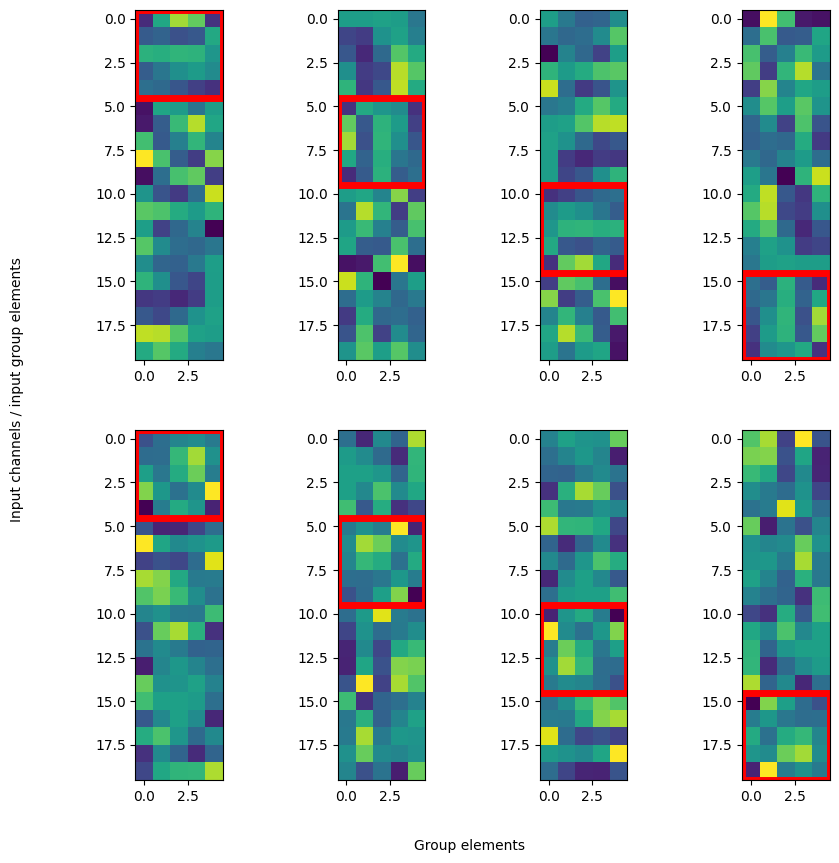

In [35]:
plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    igk.out_channels,
    igk.group.elements().numel(),
    igk.in_channels,
    igk.group.elements().numel() * igk.kernel_size,
    igk.kernel_size
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(igk.in_channels, igk.group.elements().numel())

for in_channel in range(igk.in_channels):
    for group_elem in range(igk.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].detach()
        )

        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = matplotlib.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), weights_t.shape[-1], weights_t.shape[-1], linewidth=5, edgecolor='r', facecolor='none')
        ax[in_channel, group_elem].add_patch(rect)

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va='center', rotation='vertical')

plt.show()

Φαίνεται η ίδια κίνηση περιστροφής- μετατόπισης όπως και στα πλέγματα των πυρήνων.

#### 2.2.3 Υλοποίηση της Συνέλιξης Ομάδας

Με την ανάπτυξη της επόμενης κλάσης παρέχεται η υλοποίηση της συνέλιξης ομάδας.

Σημειώσεις:
* Για την υλοποίηση αυτή, η συνάρτηση Conv2D της PyTorch θα ήταν ιδιαίτερα χρήσιμη. Ωστόσο, παρουσιάζεται ένα επιπλέον ζήτημα που αφορά τη διάσταση της ομάδας στον χάρτη χαρακτηριστικών εισόδου. Ευτυχώς, το πρόβλημα αυτό μπορεί να επιλυθεί με παρόμοιο τρόπο όπως και προηγουμένως. Κανονικά, η ολοκλήρωση ενός επιπέδου δισδιάστατης συνέλιξης πραγματοποιείται σε μια τοπική γειτονιά για όλα τα κανάλια εισόδου. Στην προκειμένη περίπτωση, απαιτείται η ολοκλήρωση να γίνει σε όλη την ομάδα. Έτσι, οι διαστάσεις της ομάδας στον χάρτη χαρακτηριστικών εισόδου θεωρούνται ως πρόσθετες διαστάσεις καναλιών. Αυτό επιτυγχάνεται με την αναδίπλωση της διάστασης της ομάδας εισόδου στη διάσταση του καναλιού εισόδου.
Ο χάρτης χαρακτηριστικών $f_{in}$ αναμορφώνεται από `[batch, in_channels, num_group_elem, spatial_1, spatial_2]` σε `[batch, in_channels x num_group_elem, spatial_1, spatial_2]`.
* Για να διασφαλιστεί η ορθή αντιστοίχιση και να εφαρμοστεί η ίδια τεχνική όπως στην ανυψωτική συνέλιξη για την εξαγωγή των αποτελεσμάτων για κάθε ξεχωριστό στοιχείο ομάδας στην έξοδο, αναμορφώνεται επίσης και ο πυρήνας από `[out_channels, num_group_elem, in_channels, num_group_elem, kernel_size, kernel_size]` σε `[out_channels x num_group_elem, in_channels x num_group_elem, kernel_size, kernel_size]`.



In [36]:
class GroupConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel = InterpolativeGroupKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )

        self.padding = padding


    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, group_dim, spatial_dim_1,
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
            spatial_dim_2]
        """

        # We now fold the group dimensions of our input into the input channel
        # dimension.



        
        x=x.reshape(
            -1,
            x.shape[1]*x.shape[2],
            x.shape[3],
            x.shape[4]
        )




        

        # We obtain convolution kernels transformed under the group.

       
        conv_kernels = self.kernel.sample()
        

        # Apply group convolution, note that the reshape folds the 'output' group
        # dimension of the kernel into the output channel dimension, and the
        # 'input' group dimension into the input channel dimension.

        
        x=torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels*self.kernel.group.elements().numel(),
                self.kernel.in_channels*self.kernel.group.elements().numel(),
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
            padding=self.padding
        )


       
        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1,
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements,
        # spatial_dim_1, spatial_dim_2], separating channel and group
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2],
        )

        return x


In [37]:
from torch.nn import AdaptiveAvgPool3d


class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        # Create the lifing convolution.

       
        self.lifting_conv = LiftingConvolution(
            group=group,
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )
        

        # Create a set of group convolutions.
        self.gconvs = torch.nn.ModuleList()

        
        for i in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    group=group,
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )
        

        # Create the projection layer. 

       
        self.projection_layer = torch.nn.AdaptiveAvgPool3d(1)
        

        # And a final linear layer for classification.
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):

        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)

        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)

        # to ensure equivariance, apply max pooling over group and spatial dims.
        x = self.projection_layer(x).squeeze()

        x = self.final_linear(x)
        return x

Για τη σύγκριση με ένα συμβατικό CNN, θα δημιουργηθεί ένα πανομοιότυπο δίκτυο με το προηγούμενο, με τη μόνη διαφορά ότι θα αποτελείται από κανονικές πράξεις συνέλιξης.


In [38]:
class CNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        self.first_conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )

        self.convs = torch.nn.ModuleList()
        for i in range(num_hidden):
            self.convs.append(
                torch.nn.Conv2d(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )

        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):

        x = self.first_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-3:])
        x = torch.nn.functional.relu(x)

        for conv in self.convs:
            x = conv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-3:])
            x = torch.nn.functional.relu(x)

        # Apply average pooling over remaining spatial dimensions.
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1).squeeze()

        x = self.final_linear(x)
        return x

## 3. Πείραμα με την υλοποίηση της Συνέλιξης Ομάδας

Για την εκπαίδευση του μοντέλου θα χρησιμοποιείται η `pytorch-lightning`. Οι λεπτομέρειες αυτού του πακέτου δεν είναι το επίκεντρο της εργασίας αλλά υπάρχουν αρκετές πληροφορίες [εδώ](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#PyTorch-Lightning).



### 3.1 Γενίκευση στη δράση ομάδας

Για να αναδειχθούν οι ικανότητες των κανονικών ομαδο-συνελικτικών δικτύων , η εκπαίδευση του μοντέλου θα πραγματοποιηθεί  στο σετ δεδομένων για εκπαίδευση MNIST . Ωστόσο, η αξιολόγηση θα γίνει σε μία εμπλουτισμένη έκδοση του σετ δεδομένων  για τεστ του MNIST ,στην οποία κάθε εικόνα έχει υποστεί τυχαία περιστροφή με μια συνεχή γωνία μεταξύ $[0, 2\pi]$.


In [39]:
# We normalize the training data.
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill=0),
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                 ])

# We demonstrate our models on the MNIST dataset.
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

# Set the random seed for reproducibility.
pl.seed_everything(1059292)

Seed set to 12


12

Απεικόνιση μερικών εικόνων εκπαίδευσης και αξιολόγησης.Όπως φαίνεται οι εικόνες αξιολόγησης έχουν περιστραφεί τυχαία.


In [40]:
# image = train_ds[].numpy().squeeze()
    
# plt.imshow(image, cmap='gray')
# plt.title(f'Label: {label}')
# plt.show()

print(len(train_ds))
# print(train_ds[0].shape())


image = train_ds[0][0]

# Print the shape of the data and label
print(f'Image shape: {image.shape}')
# print(f'Label: {label}')

60000
Image shape: torch.Size([1, 28, 28])


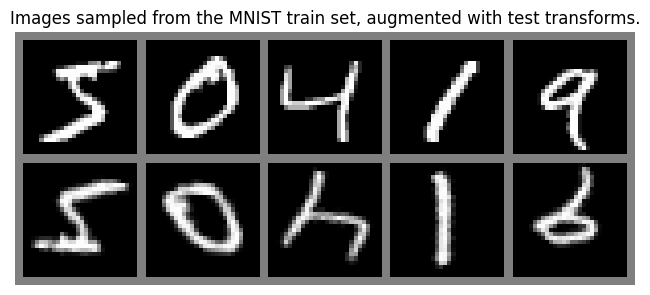

In [41]:
NUM_IMAGES =5
images = [train_ds[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_ds.data[idx].numpy()) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=NUM_IMAGES, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Images sampled from the MNIST train set, augmented with test transforms.")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [42]:
class DataModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
        optimizer = optim.AdamW(
            self.parameters(), **self.hparams.optimizer_hparams)
        return [optimizer], []

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc, prog_bar=True)

In [43]:
model_dict = {
    'CNN': CNN,
    'GCNN': GroupEquivariantCNN
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [44]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator='auto',                                             # We run on a single GPU (if possible)
                         max_epochs=10,                                                                      # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DataModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(12) # To be reproducable
        model = DataModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DataModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on test set
    val_result = trainer.test(model.to(device), test_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result

Εκπαίδευση του συμβατικού CNN.

In [45]:
# cnn_model, cnn_results = train_model(model_name="CNN",
#                                      model_hparams={"in_channels": 1,
#                                                     "out_channels": 10,
#                                                     "kernel_size": 5,
#                                                     "num_hidden":4,
#                                                     "hidden_channels":32},
#                                      optimizer_name="Adam",
#                                      optimizer_hparams={"lr": 1e-2,
#                                                         "weight_decay": 1e-4},
#                                      save_name='cnn-pretrained')



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 12



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | CNN              | 103 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)


c:\Users\IamBabis\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\IamBabis\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 938/938 [01:28<00:00, 10.61it/s, v_num=1, val_acc=0.500]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [01:28<00:00, 10.61it/s, v_num=1, val_acc=0.500]


c:\Users\IamBabis\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.80it/s]


Στη συνέχεια ,θα πραγματοποιηθεί η εκπαίδευση του ομαδο-συνελικτικού δικτύου .

Σημείωση:
* Ο αριθμός των καναλιών μειώνεται κατά το ήμισυ ώστε να αντισταθμιστεί η αυξημένη διαστατικότητα του πυρήνα. Αυτή η προσαρμογή γίνεται για να διατηρηθεί ο αριθμός των παραμέτρων εκπαίδευσης σχεδόν ίδιος και στις δύο υλοποιήσεις.


In [1]:
# gcnn_model, gcnn_results = train_model(model_name="GCNN",
#                                        model_hparams={"in_channels": 1,
#                                                       "out_channels": 10,
#                                                       "kernel_size": 5,
#                                                       "num_hidden": 4,
#                                                       "hidden_channels":16, # to account for the increase in trainable parameters due to the extra dimension in our feature maps, remove some hidden channels.
#                                                       "group":CyclicGroup(order=4).to(device)},
#                                        optimizer_name="Adam",
#                                        optimizer_hparams={"lr": 1e-2,
#                                                           "weight_decay": 1e-4},
#                                        save_name='gcnn-pretrained')




Εξετάζοντας τα τελικά αποτελέσματα και των δύο μοντέλων  
, διαπιστώνεται ότι το ομαδο-συνελικτικό δίκτυο αποδίδει σημαντικά καλύτερα σε σχέση με το CNN.Αυτό οφείλεται στο γεγονός ότι η υλοποίηση του ομαδο-συνελικτικό δικτύου είναι αμετάβλητη σε περιστροφές κατά $90$ μοίρες, γεγονός που του επιτρέπει να αναγνωρίζει τα χειρόγραφα ψηφία του συνόλου αξιολόγησης υπό τέτοιες περιστροφές. Φυσικά, δεδομένου ότι οι εικόνες δοκιμών περιστρέφονται με συνεχείς γωνίες μεταξύ $0$ και $360$ μοιρών, το ομαδο-συνελικτικό δίκτυο δεν επιτυγχάνει τέλεια ακρίβεια.ΑΥΤΟ ΦΤΙΑΝΧΕΤΑΙ ΜΕ STEERABLE


In [ ]:
print(f"CNN - Num Parameters {sum([np.prod(p.shape) for p in cnn_model.parameters()])} - Val Accuracy {cnn_results['val']*100.:4.2f}%")
print(f"GCNN - Num Parameters {sum([np.prod(p.shape) for p in gcnn_model.parameters()])} - Val Accuracy {gcnn_results['val']*100.:4.2f}%")

### 3.2 Εξέταση των δημιουργημένων χαρτών χαρακτηριστικών

Για να κατανοηθεί καλύτερα το τι συμβαίνει μέσα στο  ομαδο-συνελικτικό δίκτυο σε σύγκριση με ένα συμβατικού CNN,εξετάζεται η συμπεριφορά των χαρτών χαρακτηριστικών καθώς περιστρέφεται η εικόνα εισόδου.Παρουσιάζεται η απεικόνιση ενός μόνο καναλιού για ένα χάρτη χαρακτηριστικών στο δεύτερο επίπεδο του δικτύου για διάφορες γωνίες περιστροφής της εικόνας εισόδου.


In [ ]:
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=None)

# Get an image from the test dataset.
digit, label = train_ds[123]

# Turn it into a tensor.
digit = transforms.ToTensor()(digit)

plt.figure(figsize=(6, 6))
plt.imshow(digit.squeeze())
plt.title(f'Label: {label}')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 3]

# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/8, 8)

# Rotate the input image and push it through the normalization transform.
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)

# Create a subfigure for every rotated input.
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        rot_digit[idx, :, :].squeeze()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

In [ ]:
# Forward it through the first few layers of the CNN.
cnn_out = cnn_model.model.first_conv(rot_digit)
cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))
for i in range(2):
    cnn_out = cnn_model.model.convs[i](cnn_out)
    cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))

# Let's also see what happens after we apply projection over remaining spatial dimensions.
projected_cnn_out = torch.nn.functional.adaptive_avg_pool2d(cnn_out, 1).squeeze()

# Forward it through the first few layers of the GCNN.
gcnn_out = gcnn_model.model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(2):
    gcnn_out = gcnn_model.model.gconvs[i](gcnn_out)
    gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

# And let's see what happens if we apply the projection on this equivariant representation.
projected_gcnn_out = torch.mean(gcnn_out, dim=(-3, -2, -1))

Απεικόνιση των ενεργοποιήσεων μετά την τρίτη συνέλιξη για ένα μόνο κανάλι του συμβατικού CNN.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 3]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        cnn_out[idx, out_channel_idx, :, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

Απεικόνιση των ενεργοποιήσεων μετά την τρίτη συνέλιξη για ένα ομαδο-συνελικτικό δίκτυο

In [ ]:
plt.rcParams['figure.figsize'] = [10, 9]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
    for group_element_idx in range(gcnn_out.shape[2]):
        ax[group_element_idx ,idx].imshow(
            gcnn_out[idx, out_channel_idx, group_element_idx, :, :].detach().numpy()
        )
    ax[0, idx].set_title(f"{int(rotation)} deg")


fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
fig.text(0.04, 0.5, '$H$ dimension in feature map', va='center', rotation='vertical')

plt.show()

Τέλος, εξετάζονται οι αναπαραστάσεις μετά το βήμα της προβολής για το CNN και το ομαδο-συνελικτικό δίκτυο, απεικονίζοντας όλα τα κανάλια. Αυτές είναι οι αναπαραστάσεις αποτελούν τη βάση πάνω στην οποία εφαρμόζεται το τελικό γραμμικό επίπεδο/επίπεδα για την κατηγοριοποίηση.


In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_cnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_gcnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

## 4.Συμπεράσματα

Υλοποιήθηκε ένα βασικό κανονικό ομαδο-συνελικτικό δίκτυο που είναι ισοδύναμο στις περιστροφές 90 μοιρών. 

